# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import datetime
import pickle
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# Checking portfolio dataset
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
def clean_portfolio(portfolio):
    '''
    data cleaning for portfolio
    
    INPUT
    portfolio - portfolio dataframe to be cleaned
    
    OUTPUT
    portfolio - clean portfolio dataframe
    
    '''
    # Converting duration from day to hour
    clean_portfolio = portfolio.copy()
    clean_portfolio['duration'] = clean_portfolio['duration'] *24
    
    # Applying one hot encoding to channels column
    clean_portfolio['web'] = clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    clean_portfolio['email'] = clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    clean_portfolio['mobile'] = clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    clean_portfolio['social'] = clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # Applying one hot encoding to offer_type column
    offer_type = pd.get_dummies(clean_portfolio['offer_type'])
    
    # Dropping offer_type and channels columns
    clean_portfolio.drop(['offer_type', 'channels'], axis=1, inplace=True)
    
    # Combining portfolio and offer_type dataframes
    clean_portfolio = pd.concat([clean_portfolio, offer_type], axis=1, sort=False)
    
    return clean_portfolio


In [5]:
clean_portfolio = clean_portfolio(portfolio)

In [6]:
clean_portfolio.head(10)

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [7]:
# Exploring profile dataset
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
def clean_profile(profile):
        '''
        data cleaning for profile dataframe
    
        INPUT
        profile - profile dataframe to be cleaned
    
        OUTPUT
        profile - clean profile dataframe
    
        '''
        # Missing value encoded as 118 in age column
        profile['age'] = profile['age'].apply(lambda x: np.nan if x==118 else x)
    
        # Dropping missing values
        profile.dropna(inplace=True)
    
        # The number of days for the Starbucks membership
        profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
        profile['memberdays'] = profile['memberdays'].dt.days
    
        return profile

In [10]:
clean_profile = clean_profile(profile)

In [11]:
clean_profile.head(10)

,age,became_member_on,gender,id,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1902
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1969
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1617
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1693
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1783
13,61.0,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1844
14,26.0,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,3150
15,62.0,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,2422
16,49.0,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2877
18,57.0,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,1733


In [12]:
clean_profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,2048.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,1526.000000
25%,42.000000,2.016052e+07,49000.000000,1734.000000
50%,55.000000,2.017080e+07,64000.000000,1884.000000
75%,66.000000,2.017123e+07,80000.000000,2323.000000
max,101.000000,2.018073e+07,120000.000000,3349.000000


In [13]:
def display_customer_profile():
    '''Plotting customer information'''
    
    # Plotting customer age
    user_age = clean_profile['age'].plot(kind='hist', bins=20, title='Customer Age Distribution')
    user_age.set_xlabel("Customer Age")
    
    # Plotting Starbucks membership duration
    plt.figure()
    memberdays = clean_profile['memberdays'].plot(kind='hist', bins=50, title='Starbucks Membership Length')
    memberdays.set_xlabel("Days")
    
    # Plotting user income
    plt.figure()
    user_income = clean_profile['income'].plot(kind='hist', bins=20, title='Member Income Distribution')
    user_income.set_xlabel("Income")
    
    return 
        

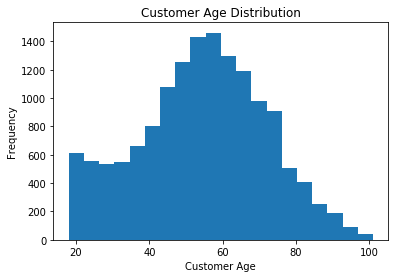

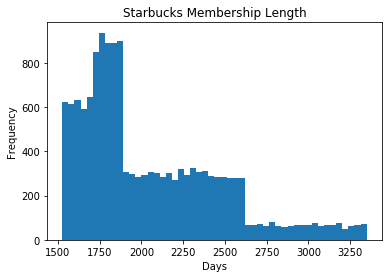

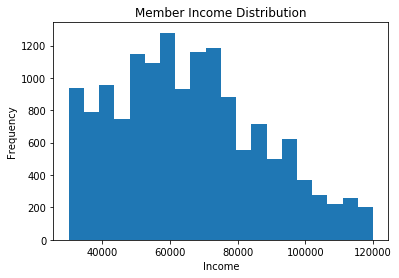

In [14]:
display_customer_profile()

In [15]:
# Exploring transcript dataset
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [16]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [17]:
# Selecting one member and exploring the transcript dataset info
transcript[transcript['person'] == '8ec6ce2a7e7949b1bf142def7d0e0586']

,event,person,time,value
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
18067,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,12,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
53177,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
85292,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,216,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
120424,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
137418,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,366,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
160235,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
189198,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,462,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
201575,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
225063,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,522,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [18]:
def clean_transcript(transcript):
    '''
    cleaning transcript dataframe and returning usable dataframe need to contain offer events
    
    INPUT
    transcript - transcript dataframe to be cleaned
    
    OUTPUT
    offer events - clean transcript dataframe
    
    '''
    
    # Extracting the rows relating the offer actions
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # Extracting the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [19]:
offer = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
offer.head(10)

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [21]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [22]:
# Checking how many times the offer was sent
offer[offer['event'] == 'offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [23]:
# Checking the same user's trancript records
offer[offer['person'] == '8ec6ce2a7e7949b1bf142def7d0e0586']

,event,person,time,value,offer_id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
18067,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,12,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
53177,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
85292,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,216,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
120424,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
137418,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,366,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
160235,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
189198,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,462,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
201575,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
225063,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,522,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4


In [24]:
offer.shape

(167581, 5)

In [25]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicates the number of offers complete for the particular user
    
    INPUT
    offer - cleaned transcript dataframe
    filename - the filename that saves that user item matrix
    
    OUTPUT
    user_item_matrix - the user item matrix:
        row is user
        column is offer
        value is number of offers that completed by the user (NaN-no offer is sent)
        
    '''
    
    # Creating an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # Focusing on only BOGO and first discount
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("Finished", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # Checking if the transaction sequence is offer received-offer viewed-offer completed
                    # If yes, it can be assumed positive reaction from the user for the offer
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # Storing the large matrix in the file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix, fh)
    fh.close()
    
    return user_item_matrix
                        

In [25]:
full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished 5.884429798752501 %
Finished 11.768859597505003 %
Finished 17.653289396257502 %
Finished 23.537719195010006 %
Finished 29.422148993762505 %
Finished 35.306578792515005 %
Finished 41.19100859126751 %
Finished 47.07543839002001 %
Finished 52.95986818877251 %
Finished 58.84429798752501 %
Finished 64.7287277862775 %
Finished 70.61315758503001 %
Finished 76.4975873837825 %
Finished 82.38201718253502 %
Finished 88.26644698128752 %
Finished 94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished 5.884429798752501 %
Finished 11.768859597505003 %
Finished 17.653289396257502 %
Finished 23.537719195010006 %
Finished 29.422148993762505 %
Finished 35.306578792515005 %
Finished 41.19100859126751 %
Finished 47.07543839002001 %
Finished 52.95986818877251 %
Finished 58.84429798752501 %
Finished 64.7287277862775 %
Finished 70.61315758503001 %
Finished 76.4975873837825 %
Finished 82.38201718253502 %
Finished 88.266446981287

In [26]:
full_df.head(5)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [28]:
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [29]:
train_offer = offer[:train_size]

In [30]:
test_offer = offer[test_size:]

In [34]:
train_df = create_user_item_matrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished 5.884429798752501 %
Finished 11.768859597505003 %
Finished 17.653289396257502 %
Finished 23.537719195010006 %
Finished 29.422148993762505 %
Finished 35.306578792515005 %
Finished 41.19100859126751 %
Finished 47.07543839002001 %
Finished 52.95986818877251 %
Finished 58.84429798752501 %
Finished 64.7287277862775 %
Finished 70.61315758503001 %
Finished 76.4975873837825 %
Finished 82.38201718253502 %
Finished 88.26644698128752 %
Finished 94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished 5.884429798752501 %
Finished 11.768859597505003 %
Finished 17.653289396257502 %
Finished 23.537719195010006 %
Finished 29.422148993762505 %
Finished 35.306578792515005 %
Finished 41.19100859126751 %
Finished 47.07543839002001 %
Finished 52.95986818877251 %
Finished 58.84429798752501 %
Finished 64.7287277862775 %
Finished 70.61315758503001 %
Finished 76.4975873837825 %
Finished 82.38201718253502 %
Finished 88.266446981287

In [35]:
train_df.head(5)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [31]:
test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished 5.884429798752501 %
Finished 11.768859597505003 %
Finished 17.653289396257502 %
Finished 23.537719195010006 %
Finished 29.422148993762505 %
Finished 35.306578792515005 %
Finished 41.19100859126751 %
Finished 47.07543839002001 %
Finished 52.95986818877251 %
Finished 58.84429798752501 %
Finished 64.7287277862775 %
Finished 70.61315758503001 %
Finished 76.4975873837825 %
Finished 82.38201718253502 %
Finished 88.26644698128752 %
Finished 94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished 5.884429798752501 %
Finished 11.768859597505003 %
Finished 17.653289396257502 %
Finished 23.537719195010006 %
Finished 29.422148993762505 %
Finished 35.306578792515005 %
Finished 41.19100859126751 %
Finished 47.07543839002001 %
Finished 52.95986818877251 %
Finished 58.84429798752501 %
Finished 64.7287277862775 %
Finished 70.61315758503001 %
Finished 76.4975873837825 %
Finished 82.38201718253502 %
Finished 88.266446981287

In [32]:
test_df.head(5)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,0.0,NaN,NaN,1.0,NaN,1.0,NaN


In [33]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat 

In [38]:
# Run this cell to omit the long process of matrix creation
#full_df = pd.read_pickle('user_item_matrix.p')

In [39]:
# Run this cell to omit the long process of matrix creation
#train_df = pd.read_pickle('train_df.p')

In [40]:
# Run this cell to omit the long process of matrix creation
#test_df = pd.read_pickle('train_df.p')

In [41]:
# Creating user-by-item matrix
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.308421
2 		 0.266894
3 		 0.266547
4 		 0.266182
5 		 0.265812
6 		 0.265436
7 		 0.265056
8 		 0.264669
9 		 0.264277
10 		 0.263878
11 		 0.263472
12 		 0.263058
13 		 0.262636
14 		 0.262206
15 		 0.261766
16 		 0.261316
17 		 0.260855
18 		 0.260383
19 		 0.259898
20 		 0.259400
21 		 0.258888
22 		 0.258361
23 		 0.257817
24 		 0.257256
25 		 0.256677
26 		 0.256078
27 		 0.255457
28 		 0.254814
29 		 0.254147
30 		 0.253454
31 		 0.252733
32 		 0.251984
33 		 0.251203
34 		 0.250390
35 		 0.249541
36 		 0.248656
37 		 0.247731
38 		 0.246765
39 		 0.245754
40 		 0.244698
41 		 0.243593
42 		 0.242436
43 		 0.241226
44 		 0.239959
45 		 0.238633
46 		 0.237246
47 		 0.235794
48 		 0.234276
49 		 0.232689
50 		 0.231030
51 		 0.229298
52 		 0.227490
53 		 0.225605
54 		 0.223641
55 		 0.221596
56 		 0.219470
57 		 0.217262
58 		 0.214971
59 		 0.212599
60 		 0.210144
61 		 0.207608
62 		 0.204992
63 		 0.202299
64 		 0

In [46]:
# Test for the best number of latent feature (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.300560
2 		 0.266610
3 		 0.266133
4 		 0.265654
5 		 0.265172
6 		 0.264687
7 		 0.264199
8 		 0.263707
9 		 0.263212
10 		 0.262713
11 		 0.262210
12 		 0.261703
13 		 0.261190
14 		 0.260673
15 		 0.260150
16 		 0.259622
17 		 0.259087
18 		 0.258545
19 		 0.257996
20 		 0.257439
21 		 0.256874
22 		 0.256301
23 		 0.255718
24 		 0.255124
25 		 0.254520
26 		 0.253905
27 		 0.253277
28 		 0.252636
29 		 0.251981
30 		 0.251311
31 		 0.250625
32 		 0.249923
33 		 0.249202
34 		 0.248462
35 		 0.247702
36 		 0.246920
37 		 0.246116
38 		 0.245287
39 		 0.244433
40 		 0.243551
41 		 0.242641
42 		 0.241701
43 		 0.240729
44 		 0.239724
45 		 0.238684
46 		 0.237607
47 		 0.236491
48 		 0.235335
49 		 0.234137
50 		 0.232896
51 		 0.231609
52 		 0.230275
53 		 0.228892
54 		 0.227459
55 		 0.225974
56 		 0.224436
57 		 0.222843
58 		 0.221194
59 		 0.219489
60 		 0.217726
61 		 0.215905
62 		 0.214025
63 		 0.212085
64 		 0

In [47]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.283166
2 		 0.268583
3 		 0.267743
4 		 0.266898
5 		 0.266052
6 		 0.265205
7 		 0.264357
8 		 0.263507
9 		 0.262656
10 		 0.261804
11 		 0.260950
12 		 0.260095
13 		 0.259238
14 		 0.258379
15 		 0.257519
16 		 0.256656
17 		 0.255792
18 		 0.254925
19 		 0.254055
20 		 0.253183
21 		 0.252308
22 		 0.251430
23 		 0.250549
24 		 0.249664
25 		 0.248775
26 		 0.247882
27 		 0.246985
28 		 0.246083
29 		 0.245176
30 		 0.244264
31 		 0.243346
32 		 0.242422
33 		 0.241491
34 		 0.240553
35 		 0.239608
36 		 0.238655
37 		 0.237694
38 		 0.236723
39 		 0.235744
40 		 0.234754
41 		 0.233754
42 		 0.232742
43 		 0.231719
44 		 0.230684
45 		 0.229635
46 		 0.228573
47 		 0.227497
48 		 0.226406
49 		 0.225299
50 		 0.224176
51 		 0.223036
52 		 0.221878
53 		 0.220701
54 		 0.219506
55 		 0.218291
56 		 0.217056
57 		 0.215800
58 		 0.214522
59 		 0.213222
60 		 0.211899
61 		 0.210553
62 		 0.209183
63 		 0.207789
64 		 0

In [48]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        # print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
        
        return None
    

In [49]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [50]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.00712413205575


In [51]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.00805506952233


In [52]:
# Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.0179478509398


In [53]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))
            

In [54]:
# Recommend offer for a particular user
recommend_offer('0009655768c64bdeb2e877511632db8f', user_mat, offer_mat)

recommend offer for user  0009655768c64bdeb2e877511632db8f
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.25
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.01
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.0
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  -0.0
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  -0.04
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.1
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  -0.45
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  -0.84


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


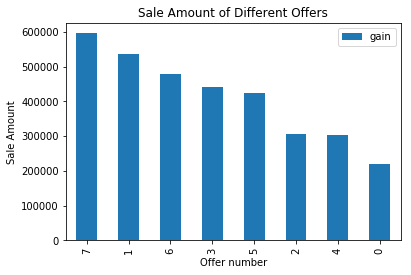

In [63]:
# Recommend top best sale offer to a new user
recommend_offer('new_user', user_mat, offer_mat)

In [56]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

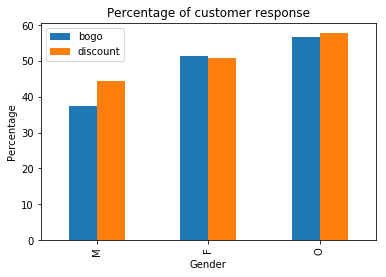

In [57]:
gender_offer(full_df)

In [58]:
clean_portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [59]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in clean_portfolio[(clean_portfolio[channel_type]==1)&(clean_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

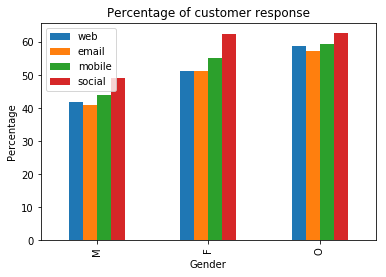

In [60]:
gender_offer_channel(full_df)

In [61]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


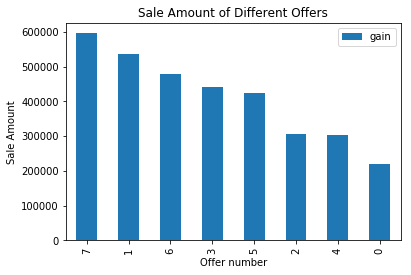

In [62]:
best_sale_offer(full_df)